In [1]:
# Input info
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/clonal_shifts/mt_dendro/"

se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simpleUnion/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
atac_col = "cluster_labels"
clone_col = "Variants"

af_t = 0.1
oth_af_t = 0.1
cov_t = 10
oth_cov_t = 10
ncells = 10
oth_ncells = 0.25 
mean_pos_cov = 0

# config
N_DONORS = 2
input_cond = "Input"

# params
min_clone_size = 10
p_thresh = 0.1 


#conds_sep = False

counts_f = ""


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from src import clonal_shifts as cs


In [3]:
sep_dir = join(outdir,"sepDonors")
if not exists(sep_dir):
    os.mkdir(sep_dir)
donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
    if not exists(join(donor_out[d], "shuffle")):
        os.mkdir(join(donor_out[d], "shuffle"))

## Load data

In [4]:
cells_dir=join(indir, "cells")
labels_df = pd.read_csv(se_cells_meta_f,sep="\t").set_index("ID")
print(labels_df.shape)
labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

den_d = {}
for d in np.arange(N_DONORS):
    den_d[str(d)] = pd.read_csv(join(indir, "dendro", f"don_{d}_mt_dendro_clust.csv"), index_col=0)

(18672, 39)
(16639, 39)


## Create groups 

donor 0


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:717: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)
ic| len(global_min): 1000
ic| len(clone_min): 7
ic| len(clone_min): 7
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all): 7


Number of groups below p-val significance: 10
Number of groups below p-val significance: 0
clone all
axs 2
bh shape (7, 14)
clone min
donor 1


ic| len(global_min): 1000
ic| len(clone_min): 5
ic| len(clone_min): 5
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all[curr_ind]): 14000
ic| len(clone_all): 5


Number of groups below p-val significance: 20
Number of groups below p-val significance: 0
clone all
axs 2
bh shape (5, 14)
clone min


,cluster_labels,den_clust,count,log2_count
0,CLP,1_C1,2,1.584963
1,CLP,1_C2,2,1.584963
2,CLP,1_C6,1,1.000000
3,DC,1_C1,1,1.000000
4,DC,1_C3,1,1.000000
...,...,...,...,...
99,neutrophil B,1_C3,6,2.807355
100,neutrophil B,1_C4,1,1.000000
101,neutrophil B,1_C5,3,2.000000
102,neutrophil B,1_C7,2,1.584963


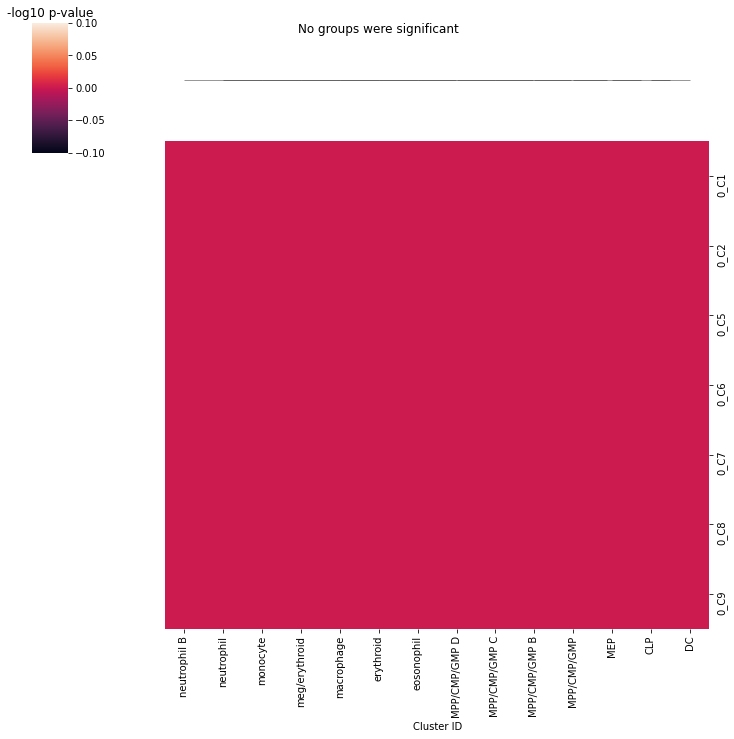

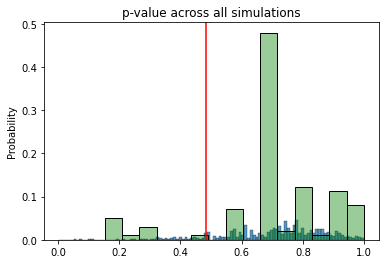

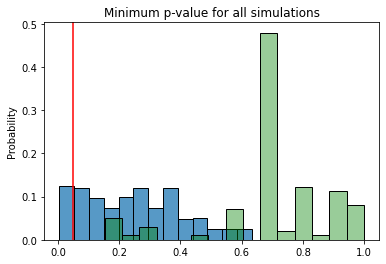

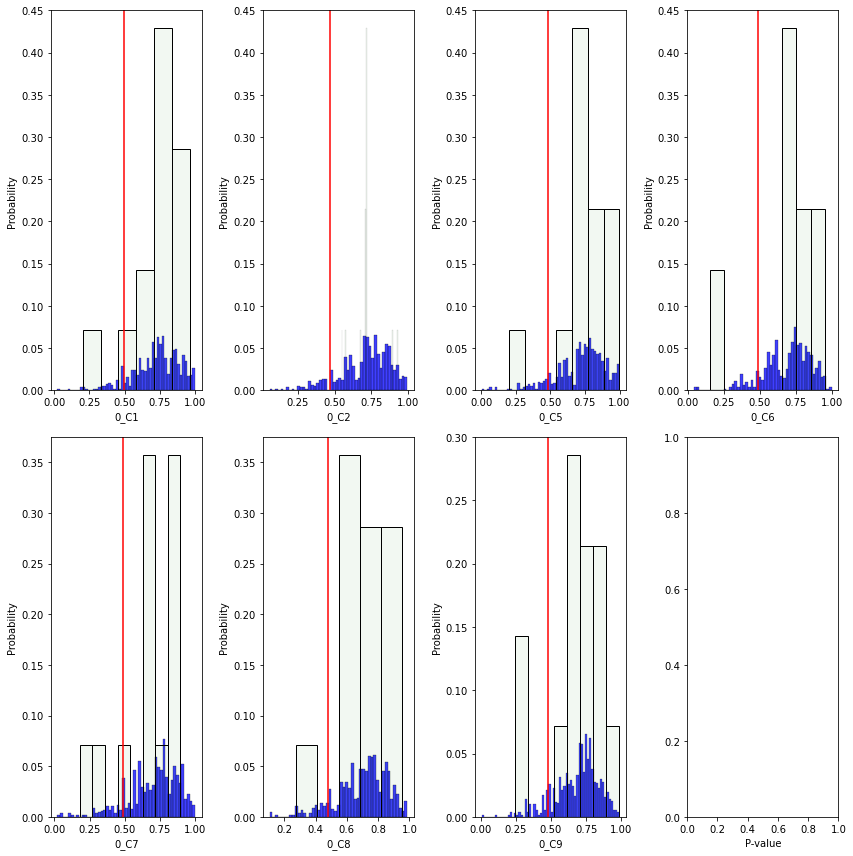

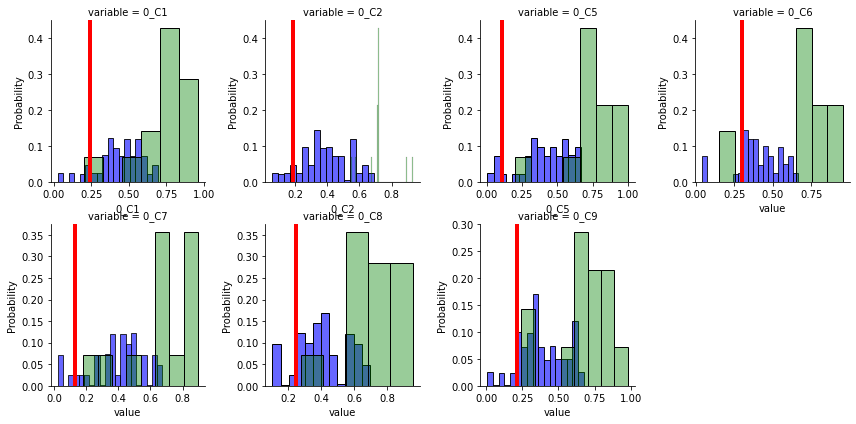

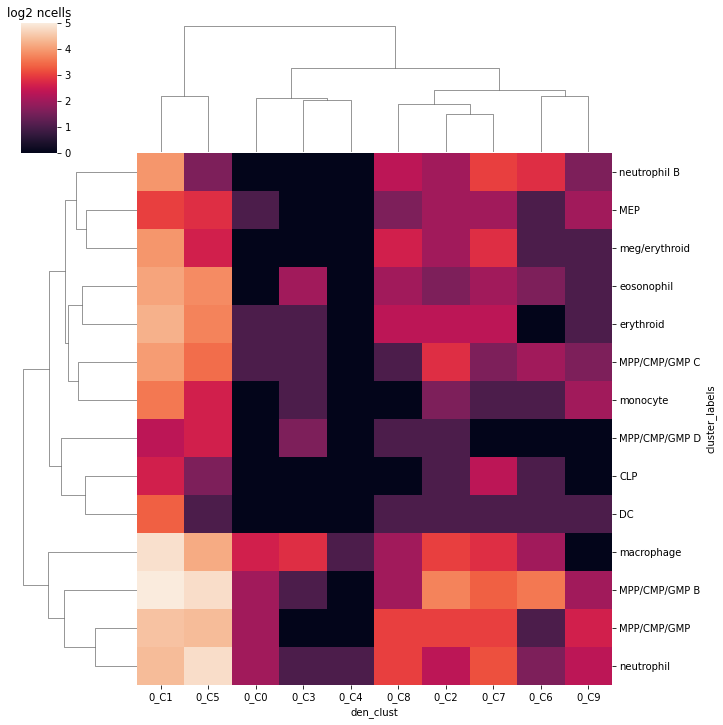

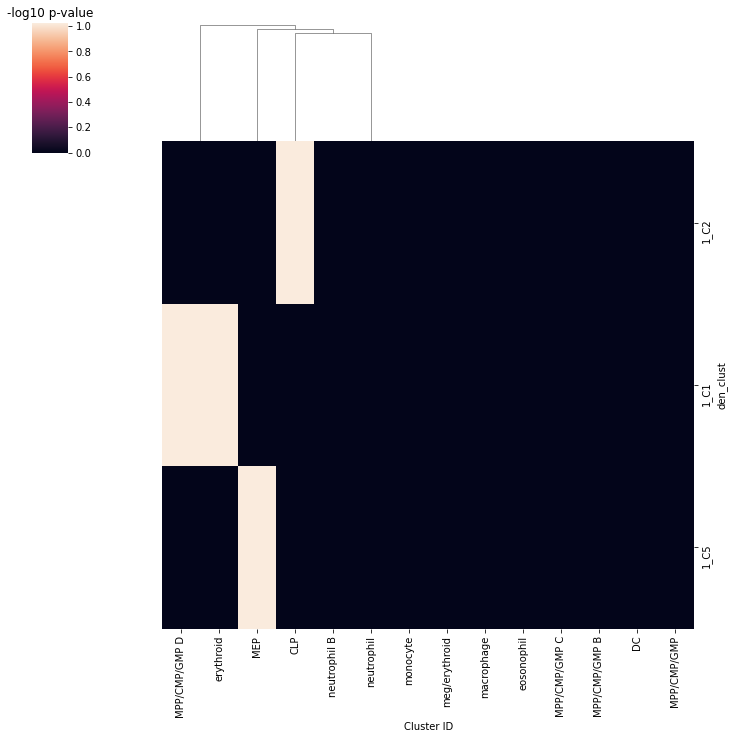

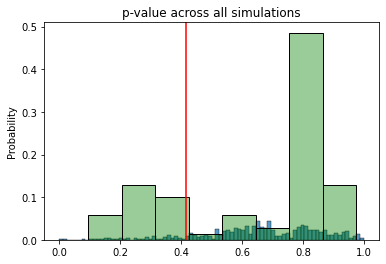

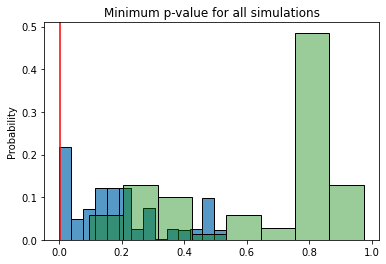

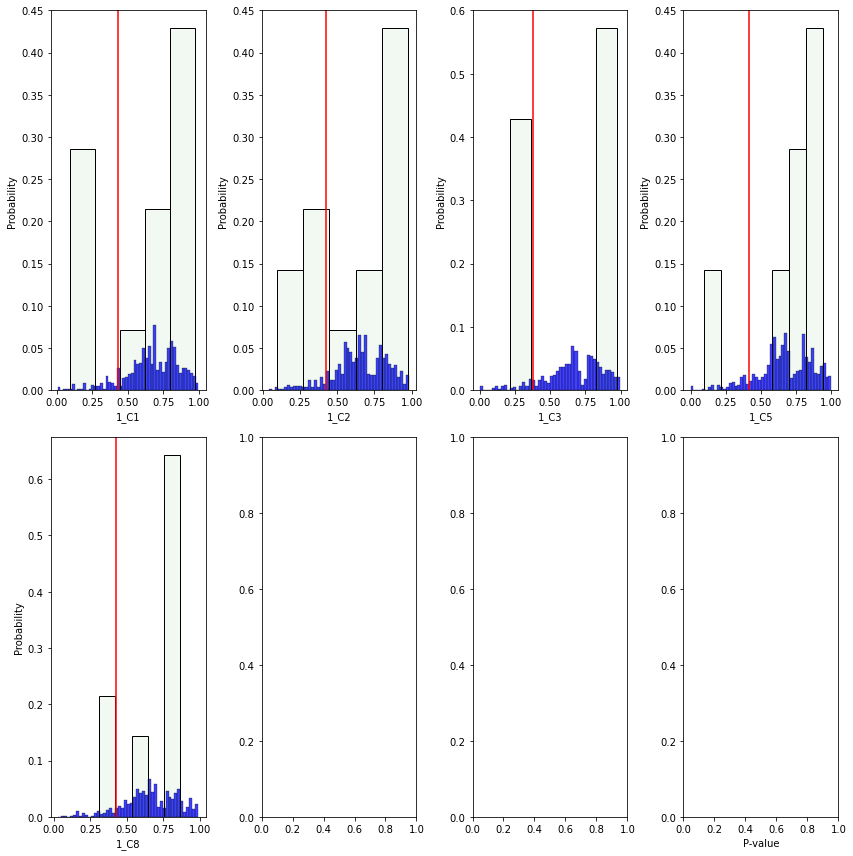

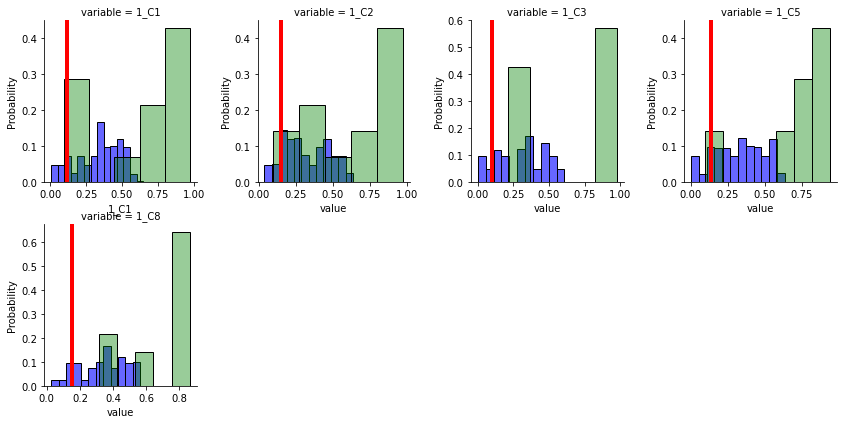

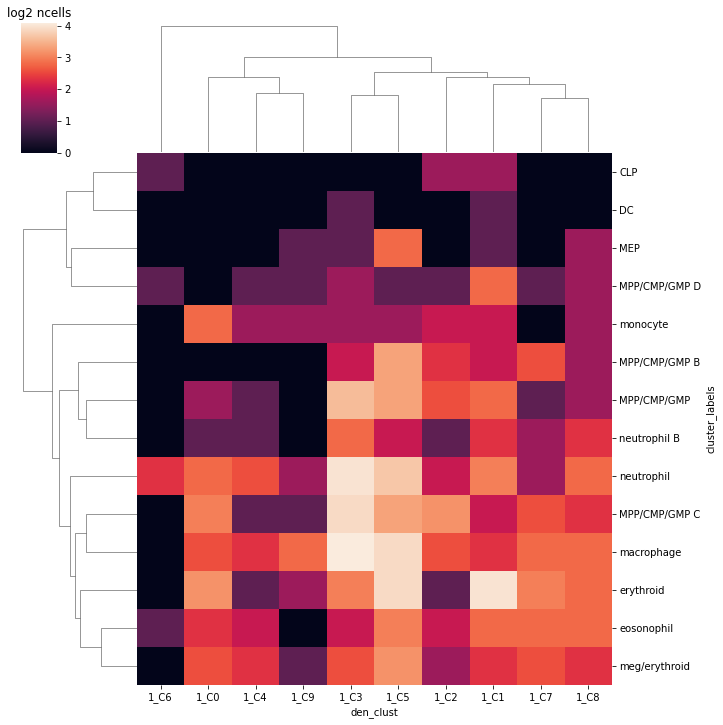

In [5]:
clone_col="den_clust"
atac_col = "cluster_labels"

for d in np.arange(N_DONORS):
    print("donor", d)
    d = str(d)
    labels = labels_df[labels_df["donor"] == d]
    data = pd.merge(left=labels[[atac_col]], right=den_d[d], left_index=True, right_index=True)
    data
    groups = data.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    name_cond_size = groups.groupby([clone_col]).size()
    name_cond_size = name_cond_size[name_cond_size>min_clone_size]
    clones_filt = name_cond_size.index

    sizes = data.groupby(clone_col).size().sort_values(ascending=False)
    sizes = sizes.loc[clones_filt].sort_values(ascending=False)
    
    clones = clones_filt.values #np.unique(groups["name"])
    clone_map = {x:ind for ind,x in enumerate(clones)}
    atac_cl = np.unique(groups[atac_col])

    # RUN
    output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,
                                                         p_thresh=p_thresh, atac_col=atac_col, 
                                                          clone_col=clone_col)
    #cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes)

    don_out = donor_out[int(d)]
    bh_enrichment_df.to_csv(join(don_out, "hypergeo_input_padjusted.csv"))
    output_df.to_csv(join(don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
    if output_df.shape[0] == 0:   
        g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
                       row_cluster=False)
        g.fig.suptitle("No groups were significant")
    else:
        g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
                       row_cluster=False)
    g.ax_heatmap.set(xlabel="Cluster ID")
    g.ax_cbar.set(title="-log10 p-value")
    plt.savefig(join(don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
    
    init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
                                              clones=clones, atac_cl=atac_cl)
    
    shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, 
                                  n_shuffle=1000, to_parallel=True, n_cpus=24)

    results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
                                                          clone_map, atac_col, 
                                                          outdir=join(don_out, "shuffle"),figs_close=False)
    
    
    # plot just the counts
    groups["log2_count"] = np.log2(groups["count"]+1)
    g = sns.clustermap(groups.pivot(index="cluster_labels",columns="den_clust", values="log2_count").fillna(0))
    plt.gca().set_title("log2 ncells")
    plt.savefig(join(don_out, "ncells.png"))
    
groups

In [ ]:
cell_pairs = []
for ind,val in groups.iterrows():
    cell_pairs.extend([[val["cluster_labels"], val["den_clust"]]]*val["count"])

In [37]:
cell_pairs = np.array(cell_pairs)

cell_pairs[:,1] = np.random.choice(cell_pairs[:,1], size= cell_pairs.shape[0],replace=False)
cell_pairs

grous_shuff = pd.DataFrame(cell_pairs,columns=[atac_col, clone_col]).groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
grous_shuff

,cluster_labels,den_clust,count
0,CLP,0_C1,3
1,CLP,0_C5,4
2,CLP,0_C6,3
3,CLP,0_C7,3
4,DC,0_C1,7
...,...,...,...
105,neutrophil B,0_C5,7
106,neutrophil B,0_C6,1
107,neutrophil B,0_C7,1
108,neutrophil B,0_C8,5


In [29]:
def get_out(shuffle, clones, bh_enrichment_df, p_thresh, clone_map, atac_col, outdir, figs_close=False):
    global_min, clone_min, global_all, clone_all = cs.get_shuffle_results(shuffle, clones, clone_map=clone_map)
    out_all = cs.plot_glob_all(bh_enrichment_df, global_all, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_all.png"))
    out_min = cs.plot_glob_min(bh_enrichment_df, global_min, p_thresh, atac_col=atac_col, out_f=join(outdir, "shuffle_min.png"))
    out_cloneall = cs.plot_clone_all(bh_enrichment_df, clone_all, p_thresh, out_f=join(outdir, "shuffle_cloneMin.png"))
    out_clonemin = cs.plot_clone_min(bh_enrichment_df, clone_min, p_thresh=p_thresh, out_f=join(outdir, "shuffle_cloneAll.png"))
    if figs_close:
        plt.close('all')
    # save results df with p-vals for each
    #results_df = pd.concat((out_all[1].melt(), out_min[1].melt(), out_cloneall[1].melt(), out_clonemin[1].melt()))
    results_df = pd.concat((out_all[1].melt().assign(method="global_all"),out_min[1].melt().assign(method="global_min"),
                            out_cloneall[1].melt().assign(method="clone_all"),
                            out_clonemin[1].melt().assign(method="clone_min")),
                           axis=0)
    import pickle
    out_d = {"sig_all":out_all, "sig_min":out_min,
             "sig_cloneAll": out_cloneall, "sig_cloneMin": out_clonemin}
    pickle.dump(out_d, open(join(outdir, "shuffle_results.p"), "wb"))
    results_df.to_csv(join(outdir, "shuffle_results_pvals.tsv"),sep="\t")
    return results_df, out_d


results_df, out_d = get_out(shuffle, clones, init_bh_enrichment, p_thresh, 
                                                      clone_map, atac_col, 
                                                      outdir=join(don_out, "shuffle"))

In [35]:
out_d["sig_cloneAll"][1]

,CLP,DC,MEP,MPP/CMP/GMP,MPP/CMP/GMP B,MPP/CMP/GMP C,MPP/CMP/GMP D,eosonophil,erythroid,macrophage,meg/erythroid,monocyte,neutrophil,neutrophil B
1_C1,True,True,False,False,False,False,True,False,True,False,False,False,False,True
1_C2,True,True,False,True,True,True,False,False,False,False,False,True,False,False
1_C3,False,True,False,True,False,True,False,False,False,True,False,False,True,True
1_C5,False,False,True,True,True,False,False,False,True,False,False,False,False,False
1_C8,False,True,True,False,False,False,True,True,False,False,False,False,False,True


In [31]:
results_df

,variable,value,method
0,CLP,0.7651,global_all
1,CLP,0.802929,global_all
2,CLP,0.532471,global_all
3,CLP,0.530071,global_all
4,CLP,0.555971,global_all
...,...,...,...
65,neutrophil B,False,clone_min
66,neutrophil B,False,clone_min
67,neutrophil B,False,clone_min
68,neutrophil B,False,clone_min


In [26]:
pd.concat((out_d["sig_all"][1].melt().assign(method="global_all"),out_d["sig_min"][1].melt().assign(method="global_min")),
         axis=0)

,variable,value,method
0,CLP,0.765100,global_all
1,CLP,0.802929,global_all
2,CLP,0.532471,global_all
3,CLP,0.530071,global_all
4,CLP,0.555971,global_all
...,...,...,...
65,neutrophil B,0.000000,global_min
66,neutrophil B,0.000000,global_min
67,neutrophil B,0.000000,global_min
68,neutrophil B,0.000000,global_min


In [9]:
results_df

,variable,value
0,CLP,0.7651
1,CLP,0.802929
2,CLP,0.532471
3,CLP,0.530071
4,CLP,0.555971
...,...,...
65,neutrophil B,False
66,neutrophil B,False
67,neutrophil B,False
68,neutrophil B,False


In [8]:
don_out

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/clonal_shifts/mt_dendro/sepDonors/donor1'

In [ ]:
# for curr_don, don_lin_mt_ncells in lin_mt_ncells.groupby("donor"):
#     curr_don_mt = don_lin_mt_ncells.set_index(["cluster_labels","donor"])
#     #lin_mt_ncells_w = curr_don_mt.reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="ncells")
#     don_lin_mt_ncells_df = don_lin_mt_ncells.pivot(index="cluster_labels", columns="Variants", values="ncells" )
#     sns.clustermap(don_lin_mt_ncells_df.fillna(0))

## Filter for input only

In [ ]:
cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
cells_meta.head()